In [1]:
import os
import gc
import warnings
warnings.filterwarnings("ignore")

In [2]:
import evaluate
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from datasets import Dataset, DatasetDict
from transformers import logging, AutoModelForSeq2SeqLM, AutoTokenizer, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from peft import LoraConfig, get_peft_model, prepare_model_for_int8_training, TaskType, PeftConfig, PeftModel
tqdm.pandas()
logging.set_verbosity_error()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gc.collect()
torch.manual_seed(42)

In [3]:
train_data = pd.read_csv('../dataset/full_train_data_summarization.csv')
validation_data = pd.read_csv('../dataset/full_validation_data_summarization.csv')
test_data = pd.read_csv('../dataset/full_test_data_summarization.csv')

In [4]:
model_name = 'VietAI/vit5-base'

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

In [6]:
def preprocess_function(examples):
  inputs = [doc for doc in examples["context"]]
  model_inputs = tokenizer(inputs, max_length=2048, truncation=True, padding=True)
  labels = tokenizer(text_target=examples["summarization"], max_length=1024, truncation=True, padding=True)
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

In [7]:
new_data = DatasetDict({
    "train": Dataset.from_dict(train_data),
    "validation": Dataset.from_dict(validation_data)
})

In [8]:
tokenized_new_data = new_data.map(preprocess_function, batched=True, num_proc=8)

Map (num_proc=8):   0%|          | 0/50413 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2200 [00:00<?, ? examples/s]

In [9]:
def compute_metrics(eval_preds):
  preds, labels = eval_preds
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels.tolist(), skip_special_tokens=True)
  decoded_preds = tokenizer.batch_decode(preds.tolist(), skip_special_tokens=True)
  bleu_metric = evaluate.load("bleu")
  references = [[reference_text] for reference_text in decoded_labels]
  bleu_scores = bleu_metric.compute(references=references, predictions=decoded_preds)
  bleu_score_1 = None
  bleu_score_2 = None
  bleu_score_3 = None
  bleu_score_4 = None
  bleu_score_avg = None
  for k, v in bleu_scores.items():
    if k == "precisions":
      bleu_score_1 = v[0]
      bleu_score_2 = v[1]        
      bleu_score_3 = v[2]        
      bleu_score_4 = v[3]
      bleu_score_avg = (bleu_score_1 + bleu_score_2 + bleu_score_3 + bleu_score_4)/4
      break
  return {
    'bleu@1': bleu_score_1,
    'bleu@2': bleu_score_2,
    'bleu@3': bleu_score_3,
    'bleu@4': bleu_score_4,
    'bleu@avg': bleu_score_avg
  }

In [9]:
def compute_metrics(eval_preds):
  preds, labels = eval_preds
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  rouge_metric = evaluate.load("rouge")
  rouge_scores = rouge_metric.compute(references=decoded_labels, predictions=decoded_preds, use_stemmer=True, rouge_types=['rouge1', 'rouge2', 'rougeL'])
  return {k: round(v, 4) for k, v in rouge_scores.items()}

In [10]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, load_in_8bit=True, device_map='auto')

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

In [11]:
# Config lora for ViT5 Base Model
lora_config = LoraConfig(
  r=8, 
  lora_alpha=16,
  target_modules=["q", "k", "v", "o", "wi", "wo", "lm_head"],
  lora_dropout=0.05,
  bias="none",
  task_type=TaskType.SEQ_2_SEQ_LM
)
model = prepare_model_for_int8_training(model)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 14,155,776 || all params: 240,106,752 || trainable%: 5.8956176292784965


In [12]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="pt")

In [13]:
training_args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name.replace('/', '_').replace('-', '_')}_model_summarization",
    learning_rate=1e-5,
    warmup_ratio=0.05,
    weight_decay=0.01,
    auto_find_batch_size=True,
    num_train_epochs=5,
    predict_with_generate=True,
    group_by_length=True,
    push_to_hub=False,
    save_total_limit=2,
    report_to='wandb',
    run_name=f'{model_name}',
    save_strategy='epoch',
    evaluation_strategy='no'
)

In [14]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_new_data["train"],
    eval_dataset=tokenized_new_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
torch.cuda.empty_cache()
gc.collect()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


20

In [15]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'loss': 16.1161, 'learning_rate': 7.92393026941363e-06, 'epoch': 0.08}
{'loss': 0.6413, 'learning_rate': 9.691806564770735e-06, 'epoch': 0.16}
{'loss': 0.5437, 'learning_rate': 9.274200283972273e-06, 'epoch': 0.24}
{'loss': 0.4925, 'learning_rate': 8.856594003173808e-06, 'epoch': 0.32}
{'loss': 0.4707, 'learning_rate': 8.438987722375345e-06, 'epoch': 0.4}
{'loss': 0.4649, 'learning_rate': 8.021381441576882e-06, 'epoch': 0.48}
{'loss': 0.4571, 'learning_rate': 7.603775160778419e-06, 'epoch': 0.56}
{'loss': 0.468, 'learning_rate': 7.1861688799799555e-06, 'epoch': 0.63}
{'loss': 0.452, 'learning_rate': 6.7685625991814915e-06, 'epoch': 0.71}
{'loss': 0.4456, 'learning_rate': 6.350956318383029e-06, 'epoch': 0.79}
{'loss': 0.4406, 'learning_rate': 5.933350037584565e-06, 'epoch': 0.87}
{'loss': 0.4377, 'learning_rate': 5.515743756786103e-06, 'epoch': 0.95}
{'loss': 0.4416, 'learning_rate': 5.098137475987639e-06, 'epoch': 1.03}
{'loss': 0.4445, 'learning_rate': 4.680531195189176e-06, 'epoch':

TrainOutput(global_step=12604, training_loss=1.077005112750006, metrics={'train_runtime': 19739.992, 'train_samples_per_second': 5.108, 'train_steps_per_second': 0.639, 'train_loss': 1.077005112750006, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

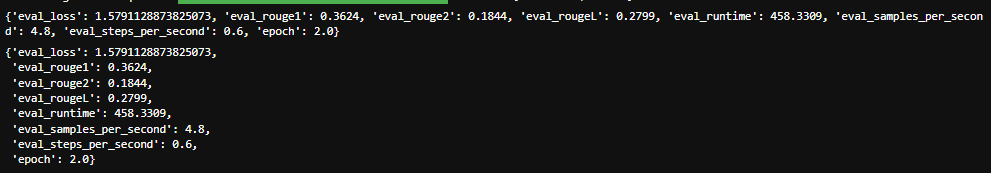

# Test Model Summarization

In [ ]:
peft_model_id = '../model_baseline/google_mt5_base_model_summarization/checkpoint-18000'
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path, load_in_8bit=True, device_map={"":0})
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(model, peft_model_id, device_map={"":0})

In [6]:
def generate_text(text):
  encoding = tokenizer(text, return_tensors="pt")
  input_ids, attention_masks = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
  outputs = model.generate(
    input_ids=input_ids, attention_mask=attention_masks,
    early_stopping=False,
    max_new_tokens=1024,
    temperature=0.7,
    top_p=0.9,
    repetition_penalty=1.2
  )
  for output in outputs:
    line = tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    torch.cuda.empty_cache()
    return line

In [10]:
test_data[f'generate_vit5'] = test_data['context'].progress_apply(lambda x: generate_text(x))

100%|██████████| 200/200 [10:00<00:00,  3.00s/it]


In [11]:
test_data

,context,summarization,generate_google_mt5
0,"Để khắc phục các nhược điểm nói trên, Viện Kho...",Viện Khoa học Fraunhofer Đức đang phát triển l...,"Viện Khoa học Fraunhofer, Đức đang phát triển ..."
1,Không nên dùng sản phẩm sát trùng mạnh như Bac...,Tránh dùng sản phẩm sát trùng mạnh. Tránh tran...,Tóm tắt ngắn gọn nội dung sau để vệ sinh khuyê...
2,"Kỳ 1: Đổi giờ học, giờ làm - đúng nhưng chưa đ...","Gần đây, Bộ Giao thông vận tải (GTVT) đã đưa r...",Bộ Giao thông vận tải (GTVT) đã đưa ra giải ph...
3,"Theo San Francisco Globe, chú hắc mã này có ng...",Frederik là một con ngựa Frieasian đến từ Hà L...,Ông Frederik là một người hâm mộ của vị vua tr...
4,Tham dự buổi làm việc có Thứ trưởng Bộ GTVT Ng...,Tham dự buổi làm việc có Thứ trưởng Bộ GTVT Ng...,Thứ trưởng Bộ GTVT Nguyễn Nhật và đại diện các...
...,...,...,...
195,"Trong giai đoạn 2015 2020, Đảng bộ VCCI đã đề ...",Đại hội Đảng bộ VCCI lần thứ VI nhiệm kỳ 2010-...,"Tại giai đoạn 2015-2020, Đảng bộ VCCI đã đề ra..."
196,Bản hit của nhạc sĩ Phạm Toàn Thắng đã có tổng...,Nhạc sĩ Phạm Toàn Thắng đã có bản hit có tổng ...,"Tổng hơn 13 triệu lượt view trong năm qua, tro..."
197,Các lực lượng chức năng đang tiến hành điều tr...,Lực lượng chức năng đang tiến hành điều tra vụ...,"Tại hầm đường bộ Phước Tượng, xe ô-tô tải Air ..."
198,"Kodaikanal, Tamil Nadu.\nMột điểm đến thân thi...","Tại Nam Ấn Độ, có nhiều điểm đến thân thiện gi...",Tìm về Kodaikanal ở Tamil Nadu. Nằm giữa những...


In [13]:
test_data.to_csv('test_vit5.csv', index=False)

In [3]:
test_vit5 = pd.read_csv('test_vit5.csv')

In [5]:
rouge_metric = evaluate.load("rouge")
rouge_scores = rouge_metric.compute(references=test_vit5['summarization'].tolist(), predictions=test_vit5['generate_vit5'].tolist(), use_stemmer=True, rouge_types=['rouge1', 'rouge2', 'rougeL'])

In [6]:
rouge_scores

{'rouge1': 0.48238559725754643,
 'rouge2': 0.2402462123862481,
 'rougeL': 0.33840521000242113}